In [1]:
! git clone https://github.com/simatec-uis/CO2Dnet
%cd unet-tf2/

Mounted at /content/drive


### Step1: Detection Influence

In [3]:
import os
import numpy as np 
import tensorflow as tf
from unet_tf2.dataset import data_pipeline
from unet_tf2.utils import build_data

In [4]:
features =  24
levels =  5

epochs = 300#@param
batch_size =  8#@param
learning_rate = 9e-4 #@param
seed = 2202
SIZE = 320
RUN_ID = 9 #@param {type:"slider", min:0, max:9, step:1}


calibration = False  #@param {type:"boolean"}
pretraining = True  #@param {type:"boolean"}
augmentation = True  #@param {type:"boolean"}

dataset = f"../data"
data_main = "results"

  
weigths_path = f'../{data_main}/weights/run={RUN_ID}.h5'
tmp_weigths_path = f'/tmp/temp_run={RUN_ID}.h5'

x_path = os.path.join(dataset, 'JPEGImages')
y_path = os.path.join(dataset, 'Mask')

train_path = os.path.join(dataset, 'ImageSets', 'Cross', f'train_{RUN_ID}.txt')
val_path = os.path.join(dataset, 'ImageSets', 'Cross', f'val_{RUN_ID}.txt')

In [5]:
train_ds = build_data(x_path, y_path, train_path, Xextension='.jpg')
validation_data = build_data(x_path, y_path, val_path, Xextension='.jpg')

train_ds = tuple([  tf.data.Dataset.from_tensors(x).unbatch() for x in train_ds ])
train_ds = data_pipeline(train_ds, augmented=augmentation, detection=True)

val_ds = tuple([  tf.data.Dataset.from_tensors(x).unbatch() for x in validation_data ])
val_ds = data_pipeline(val_ds, batch_size=1, augmented=False, detection=True)

In [6]:
from unet_tf2.utils import build_data, iou_coef, dice_coef
from unet_tf2.models.unet import Unet

from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    ModelCheckpoint,
    EarlyStopping)

metrics = None
model = Unet((SIZE, SIZE, 3),  features, levels)

callbacks = [ReduceLROnPlateau(verbose=1,
                              patience=20,         
                              factor=0.98, 
                              monitor='loss'),
             ModelCheckpoint(tmp_weigths_path,
                             monitor='val_dice_coef',
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max')]

optimizer = tf.keras.optimizers.Adam(learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[ dice_coef, Precision(), Recall(), 'accuracy'])
model.summary()

Model: "Unet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320, 320, 3)]     0         
                                                                 
 unet_layer (UnetLayer)      (None, 320, 320, 24)      17705832  
                                                                 
 conv2d_22 (Conv2D)          (None, 320, 320, 1)       25        
                                                                 
Total params: 17,705,857
Trainable params: 17,696,833
Non-trainable params: 9,024
_________________________________________________________________


In [7]:
if pretraining:
  model.load_weights(weigths_path)
  
model.fit(train_ds, epochs=epochs,  callbacks=callbacks, validation_data=val_ds)
model.load_weights(tmp_weigths_path)

Epoch 1/300
15/15 [==============================] - 27s 445ms/step - loss: 1.7562 - dice_coef: 0.6649 - precision: 0.7496 - recall: 0.7048 - accuracy: 0.7636 - val_loss: 1.9061 - val_dice_coef: 0.7382 - val_precision: 0.7213 - val_recall: 0.8604 - val_accuracy: 0.7654 - lr: 9.0000e-04
Epoch 2/300
15/15 [==============================] - 5s 306ms/step - loss: 0.7591 - dice_coef: 0.7291 - precision: 0.8173 - recall: 0.7268 - accuracy: 0.8090 - val_loss: 1.0275 - val_dice_coef: 0.7561 - val_precision: 0.7334 - val_recall: 0.8856 - val_accuracy: 0.7803 - lr: 9.0000e-04
Epoch 3/300
15/15 [==============================] - 4s 290ms/step - loss: 0.4360 - dice_coef: 0.7336 - precision: 0.8695 - recall: 0.6963 - accuracy: 0.8171 - val_loss: 0.5378 - val_dice_coef: 0.6343 - val_precision: 0.7489 - val_recall: 0.6617 - val_accuracy: 0.7312 - lr: 9.0000e-04
Epoch 4/300
15/15 [==============================] - 4s 292ms/step - loss: 0.3588 - dice_coef: 0.7517 - precision: 0.8784 - recall: 0.7179 - 

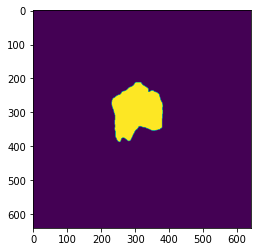

../ablation-study-allindata-v2/detection_pretraining_augmentation/run9/segmented_0.png


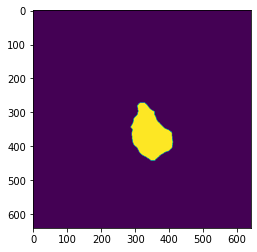

../ablation-study-allindata-v2/detection_pretraining_augmentation/run9/segmented_1.png


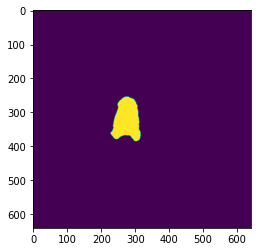

../ablation-study-allindata-v2/detection_pretraining_augmentation/run9/segmented_2.png


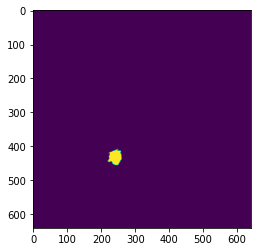

../ablation-study-allindata-v2/detection_pretraining_augmentation/run9/segmented_3.png


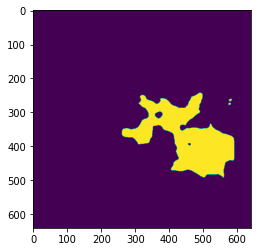

../ablation-study-allindata-v2/detection_pretraining_augmentation/run9/segmented_4.png


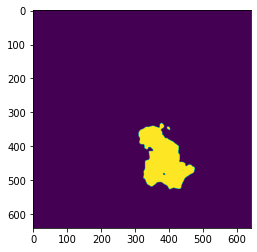

../ablation-study-allindata-v2/detection_pretraining_augmentation/run9/segmented_5.png


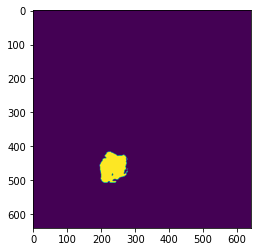

../ablation-study-allindata-v2/detection_pretraining_augmentation/run9/segmented_6.png


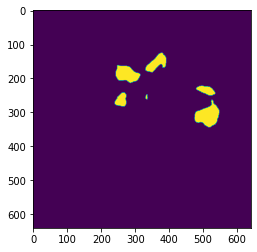

../ablation-study-allindata-v2/detection_pretraining_augmentation/run9/segmented_7.png


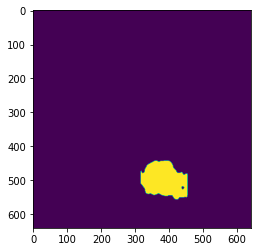

../ablation-study-allindata-v2/detection_pretraining_augmentation/run9/segmented_8.png


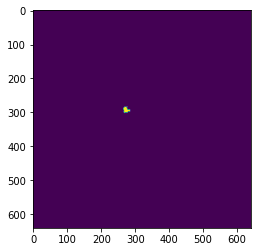

../ablation-study-allindata-v2/detection_pretraining_augmentation/run9/segmented_9.png


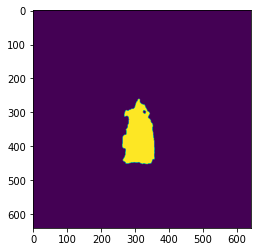

../ablation-study-allindata-v2/detection_pretraining_augmentation/run9/segmented_10.png


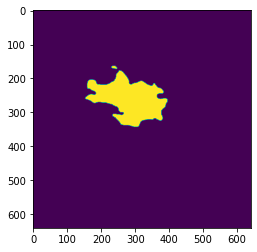

../ablation-study-allindata-v2/detection_pretraining_augmentation/run9/segmented_11.png


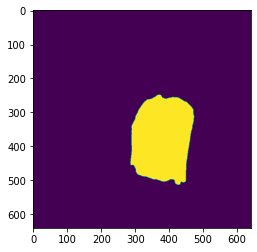

../ablation-study-allindata-v2/detection_pretraining_augmentation/run9/segmented_12.png


In [8]:
import cv2
import matplotlib.pyplot as plt 
from unet_tf2.dataset import get_coords

MODE = "predictions"
save_path = f"../{data_main}/{MODE}/run{RUN_ID}"

if not os.path.exists(save_path):
  os.mkdir(save_path)
  

val_ds = tuple([  tf.data.Dataset.from_tensors(x).unbatch() for x in validation_data ])
val_ds = data_pipeline(val_ds, batch_size=1, augmented=False, detection=True, original=True)

id = 0;
for sample in val_ds:

  x, (y_crop, y) = sample


  cord_h, cord_w, h_size, w_size = get_coords(y[0])


  y_pred = model.predict(x)
  y_pred = tf.image.resize(y_pred, [h_size, w_size] )
  y_pred = y_pred.numpy()
  y_pred = 1*(y_pred > 0.5)
  temp = np.uint8( y_pred[0]*255 )

  y_pred = np.zeros( y.shape )
  y_pred[:, cord_h:cord_h+h_size, cord_w:cord_w+w_size] = temp
  y_pred = y_pred[0,..., 0]

  plt.imshow(y_pred)
  plt.show()

  img_save = f"segmented_{id}.png"
  img_path = os.path.join(save_path, img_save)

  print(img_path)
  cv2.imwrite(img_path, y_pred)

  id = id+1

In [9]:
%cd  ../data
!python save_results.py --mode {MODE} --runid {RUN_ID}

/content/drive/.shortcut-targets-by-id/1gOanLoDPxpluM1Y-CJB6_Dk1wua7o39m/hdsp/skin-care/baseline/ablation-study-allindata-v2
Found 13 files belonging to 1 classes.
2022-09-02 21:18:47.180612: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Found 13 files belonging to 1 classes.
[9, 0.8212723, 0.83030576, 0.83325267]
